In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import utils
import tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
IMAGE_PATH = '/content/drive/MyDrive/colab_notebooks/data/Capstone/bee_imgs/'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50

In [4]:
os.listdir("/content/drive/MyDrive/colab_notebooks/data/Capstone/")

['bee_data.csv', 'bee_image.zip', 'bee_imgs']

In [5]:
os.listdir(IMAGE_PATH)[-10:]

['003_230.png',
 '004_063.png',
 '003_259.png',
 '003_235.png',
 '004_170.png',
 '003_245.png',
 '003_273.png',
 '004_264.png',
 '003_249.png',
 '004_128.png']

In [6]:
bee_df = pd.read_csv("/content/drive/MyDrive/colab_notebooks/data/Capstone/bee_data.csv")
bee_df.head(10)

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
5,041_071.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
6,041_065.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
7,041_064.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
8,041_070.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
9,041_058.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [7]:
bee_df.shape

(5172, 9)

In [8]:
bee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file             5172 non-null   object
 1   date             5172 non-null   object
 2   time             5172 non-null   object
 3   location         5172 non-null   object
 4   zip code         5172 non-null   int64 
 5   subspecies       5172 non-null   object
 6   health           5172 non-null   object
 7   pollen_carrying  5172 non-null   bool  
 8   caste            5172 non-null   object
dtypes: bool(1), int64(1), object(7)
memory usage: 328.4+ KB


In [9]:
image_files = list(os.listdir(IMAGE_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5173


In [10]:
file_names = list(bee_df['file'])
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 5172


In [11]:
def read_image_sizes(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    return list(image.shape)

In [12]:
np.stack([read_image_sizes(filename) for filename in bee_df['file'][:50]])

array([[115, 164,   3],
       [201,  90,   3],
       [132, 167,   3],
       [134,  97,   3],
       [147, 106,   3],
       [194, 135,   3],
       [159, 170,   3],
       [132,  95,   3],
       [126, 190,   3],
       [156, 189,   3],
       [132, 142,   3],
       [ 69, 119,   3],
       [105, 104,   3],
       [108,  99,   3],
       [220, 159,   3],
       [130, 137,   3],
       [183, 161,   3],
       [182, 144,   3],
       [186, 225,   3],
       [150, 153,   3],
       [101, 140,   3],
       [136, 127,   3],
       [ 95, 115,   3],
       [ 78, 103,   3],
       [180, 113,   3],
       [118, 126,   3],
       [238, 167,   3],
       [133, 136,   3],
       [159, 118,   3],
       [146,  95,   3],
       [145, 182,   3],
       [ 89,  99,   3],
       [126, 176,   3],
       [172, 127,   3],
       [210, 163,   3],
       [ 96, 111,   3],
       [127, 162,   3],
       [168, 146,   3],
       [143, 141,   3],
       [129, 155,   3],
       [ 86, 139,   3],
       [222, 168

In [13]:
m = np.stack(bee_df['file'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['width','height','color'])
bee_df = pd.concat([bee_df,df],axis=1, sort=False)

In [14]:
bee_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,width,height,color
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,115,164,3
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,201,90,3
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,132,167,3
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,134,97,3
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,147,106,3


In [16]:
bee_df.to_csv('/content/drive/MyDrive/colab_notebooks/data/Capstone/bee_data_w_image.csv')

''

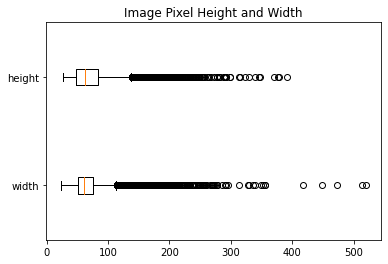

In [32]:
plt.figure()
plt.boxplot([bee_df.width, bee_df.height], labels = ['width', 'height'], vert = False)

plt.title('Image Pixel Height and Width')
;

Scale to 100 x 100 px.

In [34]:
tmp = bee_df.groupby(['zip code'])['location'].value_counts()

zip code  location            
3431      Keene, NH, USA           92
30607     Athens, GA, USA         579
          Athens, Georgia, USA    472
50315     Des Moines, IA, USA     973
70115     New Orleans, LA, USA    170
Name: location, dtype: int64

In [35]:
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

,zip code,location,Images
0,3431,"Keene, NH, USA",92
1,30607,"Athens, GA, USA",579
2,30607,"Athens, Georgia, USA",472
3,50315,"Des Moines, IA, USA",973
4,70115,"New Orleans, LA, USA",170
5,77511,"Alvin, TX, USA",737
6,95070,"Saratoga, CA, USA",2000
7,95124,"San Jose, CA, USA",149


In [38]:
bee_df = bee_df.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')
bee_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,width,height,color
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,115,164,3
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,201,90,3
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,132,167,3
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,134,97,3
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,147,106,3


In [39]:
bee_df.location.value_counts()

Saratoga, CA, USA       2000
Athens, GA, USA         1051
Des Moines, IA, USA      973
Alvin, TX, USA           737
New Orleans, LA, USA     170
San Jose, CA, USA        149
Keene, NH, USA            92
Name: location, dtype: int64

In [41]:
bee_df['date_time'] = pd.to_datetime(bee_df['date'] + ' ' + bee_df['time'])
bee_df["year"] = bee_df['date_time'].dt.year
bee_df["month"] = bee_df['date_time'].dt.month
bee_df["day"] = bee_df['date_time'].dt.day
bee_df["hour"] = bee_df['date_time'].dt.hour
bee_df["minute"] = bee_df['date_time'].dt.minute

In [42]:
bee_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,width,height,color,date_time,year,month,day,hour,minute
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,115,164,3,2018-08-28 16:07:00,2018,8,28,16,7
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,201,90,3,2018-08-28 16:07:00,2018,8,28,16,7
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,132,167,3,2018-08-28 16:07:00,2018,8,28,16,7
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,134,97,3,2018-08-28 16:07:00,2018,8,28,16,7
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,147,106,3,2018-08-28 16:07:00,2018,8,28,16,7


### Train-test-split

In [44]:
train_df, test_df = train_test_split(bee_df, test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE, 
                                     stratify=bee_df['subspecies'])

In [45]:
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, 
                                    random_state=RANDOM_STATE, 
                                    stratify=train_df['subspecies'])

In [46]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 3309
Test  set rows: 1035
Val   set rows: 828


In [47]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    return image[:,:,:IMAGE_CHANNELS]

In [48]:
def categories_encoder(dataset, var='subspecies'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [49]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

## CNN

In [56]:
model1 = Sequential()


model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
#model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))


model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                                 
 dense_2 (Dense)             (None, 7)                 280007    
                                                                 
Total params: 280,455
Trainable params: 280,455
Non-trainable params: 0
_________________________________________________________________


In [58]:
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    verbose=1
)

Epoch 1/10
13/13 [==============================] - 1s 60ms/step - loss: 2.9849 - accuracy: 0.4379 - val_loss: 1.6681 - val_accuracy: 0.5568
Epoch 2/10
13/13 [==============================] - 1s 40ms/step - loss: 1.2758 - accuracy: 0.5775 - val_loss: 0.9634 - val_accuracy: 0.6437
Epoch 3/10
13/13 [==============================] - 1s 39ms/step - loss: 0.8639 - accuracy: 0.7325 - val_loss: 0.7719 - val_accuracy: 0.7476
Epoch 4/10
13/13 [==============================] - 1s 39ms/step - loss: 0.6782 - accuracy: 0.7736 - val_loss: 0.6170 - val_accuracy: 0.7705
Epoch 5/10
13/13 [==============================] - 1s 39ms/step - loss: 0.5571 - accuracy: 0.7906 - val_loss: 0.5553 - val_accuracy: 0.7838
Epoch 6/10
13/13 [==============================] - 1s 40ms/step - loss: 0.4984 - accuracy: 0.8090 - val_loss: 0.5235 - val_accuracy: 0.7911
Epoch 7/10
13/13 [==============================] - 1s 42ms/step - loss: 0.4546 - accuracy: 0.8250 - val_loss: 0.4737 - val_accuracy: 0.8056
Epoch 8/10
13

In [63]:
model1.history

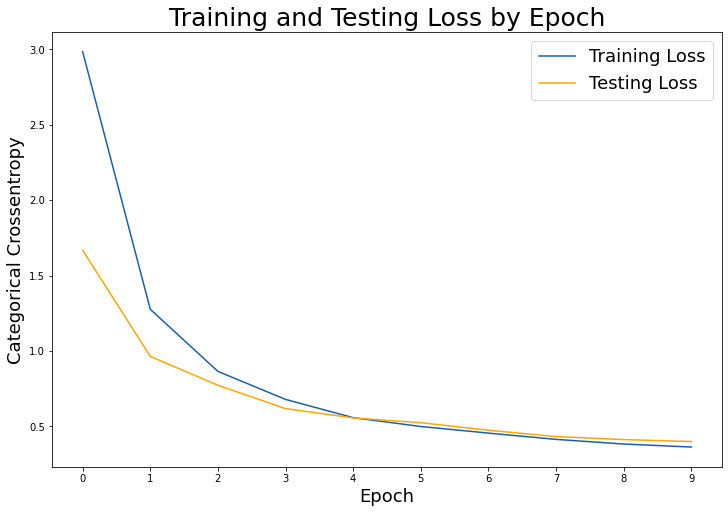

In [65]:
def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Set figure size
    plt.figure(figsize=(12, 8))

    # Generate line plot of training, testing loss over epochs
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')

    # Set title
    plt.title('Training and Testing Loss by Epoch', fontsize = 25)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylabel('Categorical Crossentropy', fontsize = 18)
    plt.xticks(np.arange(10), np.arange(10))

    plt.legend(fontsize = 18);

plot_loss(model1.history)